In [45]:
from pyspark.sql import SQLContext
from pyspark.sql import functions as sf
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DateType
from datetime import date, timedelta
import datetime as dt
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import col, avg, sum, first
import numpy as np
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import pandas as pd
from pyspark.ml.regression import LinearRegression
import pyspark

In [9]:
log4jLogger = sc._jvm.org.apache.log4j
LOGGER = log4jLogger.LogManager.getLogger(__name__)
LOGGER.error("pyspark script logger initialized")

In [10]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.208:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.208:7077 appName=spark>

In [11]:
base_path = "/home/test5/Desktop/smart-meters-in-london/"
sqlcontext = SQLContext(sc)

In [12]:
cluster_feature = sqlcontext.read.csv(path=base_path+"k=8_means_Feature.csv",header=True,inferSchema=True)
# cluster_feature = cluster_feature.drop("_c0","date2","diff_energy_week_t_1","rnk","month")
# cluster_feature = cluster_feature.withColumn("windSpeed",cluster_feature["windSpeed"].cast("float"))
# cluster_feature = cluster_feature.withColumn("dewPoint",cluster_feature["dewPoint"].cast("float"))
cluster_feature.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- cluster_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (

In [13]:
cluster_feature = cluster_feature.withColumn("holiday1",sf.when((col("Weekday/end")==1) | (col("holiday")==1),1).otherwise(0))
cluster_feature = cluster_feature.drop("_c0","diff_energy_week_t_1","date2","holiday","month","Weekday/end")
cluster_feature = cluster_feature.withColumnRenamed("holiday1","holiday")
cluster_feature.take(1)

[Row(cluster_id=1, date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=26.887, weekDay='Tue', 1_diff_energy_t_0=27.66, 2_diff_energy_t_0=24.897, 3_diff_energy_t_0=26.95, 4_diff_energy_t_0=28.878, 5_diff_energy_t_0=30.769, 6_diff_energy_t_0=24.581, 7_diff_energy_t_0=36.469, 1_diff_energy_t_1=29.753, 2_diff_energy_t_1=34.267, 3_diff_energy_t_1=32.199, 4_diff_energy_t_1=39.245, 5_diff_energy_t_1=39.218, 6_diff_energy_t_1=27.46, 7_diff_energy_t_1=36.102, 1_diff_energy_t_2=33.561, 2_diff_energy_t_2=36.934, 3_diff_energy_t_2=35.116, 4_diff_energy_t_2=43.89, 5_diff_energy_t_2=44.017, 6_diff_energy_t_2=34.315, 7_diff_energy_t_2=33.88, diff_energy_week_t_2=28.705, diff_energy_week_t_3=29.39, diff_energy_week_t_4=27.736, rnk=32, mean_1=31.05083333333333, mean_2=31.69304166666667, mean_3=30.185666666666663, mean_4=33.873416666666664, mean_5=35.266625000000005, mean_6=34.071625000000004, mean_7=34.696125, min_1=18.814, max_1=40.693, min_2=20.052, max_2=42.29, min_3=17.198, max_3=38.897

In [14]:
outputCols = ["weekDay_index","precipType_index","summary_index"]
df_encoded = cluster_feature
df_encoded = df_encoded.na.drop()
for col in outputCols: 
    encoder = OneHotEncoder(inputCol=col, outputCol="category_{}".format(col))
    df_encoded = encoder.transform(df_encoded).cache()
df_encoded = df_encoded.drop("rnk")
df_encoded.printSchema()

root
 |-- cluster_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_d

In [15]:
inputCols = ["weekDay","precipType","summary",]
columns = df_encoded.columns
feature_col = columns[4:]
feature_col.append(columns[2])
feature_col = set(feature_col) - set(inputCols)
feature_col = feature_col - set(outputCols)
feature_col = list(feature_col)
df_encoded = df_encoded.na.drop()
len(feature_col)

59

In [16]:
vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features")
df_feature = vecAssembler.transform(df_encoded)
df_feature.take(1)

[Row(cluster_id=1, date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=26.887, weekDay='Tue', 1_diff_energy_t_0=27.66, 2_diff_energy_t_0=24.897, 3_diff_energy_t_0=26.95, 4_diff_energy_t_0=28.878, 5_diff_energy_t_0=30.769, 6_diff_energy_t_0=24.581, 7_diff_energy_t_0=36.469, 1_diff_energy_t_1=29.753, 2_diff_energy_t_1=34.267, 3_diff_energy_t_1=32.199, 4_diff_energy_t_1=39.245, 5_diff_energy_t_1=39.218, 6_diff_energy_t_1=27.46, 7_diff_energy_t_1=36.102, 1_diff_energy_t_2=33.561, 2_diff_energy_t_2=36.934, 3_diff_energy_t_2=35.116, 4_diff_energy_t_2=43.89, 5_diff_energy_t_2=44.017, 6_diff_energy_t_2=34.315, 7_diff_energy_t_2=33.88, diff_energy_week_t_2=28.705, diff_energy_week_t_3=29.39, diff_energy_week_t_4=27.736, mean_1=31.05083333333333, mean_2=31.69304166666667, mean_3=30.185666666666663, mean_4=33.873416666666664, mean_5=35.266625000000005, mean_6=34.071625000000004, mean_7=34.696125, min_1=18.814, max_1=40.693, min_2=20.052, max_2=42.29, min_3=17.198, max_3=38.897, min_4=

In [17]:
df_feature = df_feature.withColumnRenamed("energy(kWh/h)","label")
df_feature = df_feature.withColumn("date",df_feature["date"].cast(DateType()))
df_feature.printSchema()

root
 |-- cluster_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_diff_energy_t_

##  actual and Predicted for given day

In [18]:
def get_aggregate(df):
    list = ["date","hour"]
    df = df.groupBy(list).agg(sum("label"),sum("prediction"))    
    return df

def select_predicted_actual(df,date,LCLid=None):
    list = []
    if LCLid != None:
        list = df.where((df["LCLid"] == LCLid) & (df["date"] == date)).select("label","prediction").collect()
    else:
        list = df.where((df["date"] == date)).select("label","prediction").collect()
    actual = [int(row['label']) for row in list]
    predicted = [int(row['prediction']) for row in list]
    return actual,predicted

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(np.abs((y_true - y_pred)**2)))

# Train-Test Split

In [19]:
train_df_cluster = []
val_df_cluster = []
test_df_cluster = []
num_of_cluster = 8
for cluster_id in range(num_of_cluster):
    train_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] <= date(2013,10,15)))
    val_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] <= date(2013,10,31)) & (df_feature["date"] >= date(2013,10,15)))
    test_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] > date(2013,10,31)))# & (df_feature["date"] <= date(2013,1,2)))
    print("Train_point = {},val_df = {}, Test_point = {}, cId = {}".format(train_df.count(),val_df.count(),test_df.count(),cluster_id))
    train_df_cluster.append(train_df)
    val_df_cluster.append(val_df)
    test_df_cluster.append(test_df)

Train_point = 6904,val_df = 408, Test_point = 1464, cId = 0
Train_point = 6904,val_df = 408, Test_point = 1464, cId = 1
Train_point = 6904,val_df = 408, Test_point = 1464, cId = 2
Train_point = 6904,val_df = 408, Test_point = 1464, cId = 3
Train_point = 6904,val_df = 408, Test_point = 1464, cId = 4
Train_point = 6904,val_df = 408, Test_point = 1464, cId = 5
Train_point = 6904,val_df = 408, Test_point = 1464, cId = 6
Train_point = 6904,val_df = 408, Test_point = 1464, cId = 7


## RF

In [20]:
pred_val = []
val_pred_val = []
flag = 0
for cluster_id in range(num_of_cluster):
    rf = RandomForestRegressor(numTrees=20,maxDepth=10,maxBins=128,seed=4)
    model = rf.fit(train_df_cluster[cluster_id])
    rf_pred_val = model.transform(test_df_cluster[cluster_id])
    rf_val_pred_val = model.transform(val_df_cluster[cluster_id])
    if flag == 0:
        val_pred_val = sqlcontext.createDataFrame([],rf_val_pred_val.schema)
        pred_val = sqlcontext.createDataFrame([],rf_pred_val.schema)
        flag = 1
    pred_val = pred_val.union(rf_pred_val)
    pred_val = pred_val.cache()
    val_pred_val = val_pred_val.union(rf_val_pred_val)
    val_pred_val = val_pred_val.cache()

## GBT

In [ ]:
pred_val = []
val_pred_val = []
flag = 0
for cluster_id in range(num_of_cluster):
    gbt = GBTRegressor(maxBins=128,maxDepth=10)
    gbt_model = gbt.fit(train_df_cluster[cluster_id])
    gbt_pred_val = model.transform(test_df_cluster[cluster_id])
    gbt_val_pred_val = model.transform(val_df_cluster[cluster_id])
    if flag == 0:
        val_pred_val = sqlcontext.createDataFrame([],gbt_val_pred_val.schema)
        pred_val = sqlcontext.createDataFrame([],gbt_pred_val.schema)
        flag = 1
    pred_val = pred_val.union(gbt_pred_val)
    pred_val = pred_val.cache()
    val_pred_val = val_pred_val.union(gbt_val_pred_val)
    val_pred_val = val_pred_val.cache()

In [21]:
val_pred_val = val_pred_val.select("date","hour","cluster_id","prediction","label")
val_pred_val.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- cluster_id: integer (nullable = true)
 |-- prediction: double (nullable = false)
 |-- label: double (nullable = true)



In [22]:
LR_pivot = val_pred_val.groupBy("date","hour").pivot("cluster_id").agg(first("prediction"))
LR_pivot.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)



In [23]:
val_pred_val.where((LR_pivot["date"] == date(2013,10,1)) & (LR_pivot["hour"] == 1)).show()
LR_pivot.where((LR_pivot["date"] == date(2013,10,1)) & (LR_pivot["hour"] == 1)).show(2)


+----+----+----------+----------+-----+
|date|hour|cluster_id|prediction|label|
+----+----+----------+----------+-----+
+----+----+----------+----------+-----+

+----+----+---+---+---+---+---+---+---+---+
|date|hour|  0|  1|  2|  3|  4|  5|  6|  7|
+----+----+---+---+---+---+---+---+---+---+
+----+----+---+---+---+---+---+---+---+---+



In [24]:
LR_actual = val_pred_val.groupBy("date","hour").sum("label")
LR_actual.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sum(label): double (nullable = true)



In [25]:
LR_feature = LR_pivot.join(LR_actual,["date","hour"])
LR_feature = LR_feature.withColumnRenamed("sum(label)","label")
LR_feature.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- label: double (nullable = true)



In [26]:
feature_col = LR_feature.columns
feature_col = feature_col[2:10]
feature_col

['0', '1', '2', '3', '4', '5', '6', '7']

In [41]:
vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features")
df_feature = vecAssembler.transform(LR_feature)
df_feature.take(1)

[Row(date=datetime.date(2013, 10, 23), hour=10, 0=355.86641914398695, 1=37.47424767213652, 2=298.6944581873407, 3=10.961227767082402, 4=385.3858608292361, 5=98.95995366156907, 6=151.1262115744309, 7=174.85446834055335, label=1414.518, features=DenseVector([355.8664, 37.4742, 298.6945, 10.9612, 385.3859, 98.96, 151.1262, 174.8545]))]

In [46]:
scaler = MinMaxScaler(inputCol="features",outputCol="scaled_features")
df_feature = scaler.fit(df_feature).transform(df_feature)
df_feature = df_feature.drop("features")
df_feature = df_feature.withColumnRenamed("scaled_features","features")

In [72]:
# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout
# from elephas.ml_model import ElephasEstimator
# model = Sequential()
# model.add(Dense(128,input_dim=8,activation="relu"))
# model.add(Dense(64,activation="relu"))
# model.add(Dense(1,activation="linear"))
# model.compile(loss="mse",optimizer="adam",metrics=["mae","mse"])
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
_________________________________________________________________


In [79]:
# from elephas.ml_model import ElephasEstimator
# estimator = ElephasEstimator(model,epochs=50,batch_size=32)
# # lrModel = estimator.fit(df_feature)
# # from elephas.spark_model import SparkModel
# # spark_model = SparkModel(model,frequency="epoch")
# # spark_model.fit(df_feature.select("features","label").rdd,epochs=20,batch_size=32)

TypeError: Method __init__ forces keyword arguments.

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [47]:
lr = LinearRegression(solver="auto",loss = "huber")
lrModel = lr.fit(df_feature)

In [48]:
df_feature.take(1)

[Row(date=datetime.date(2013, 10, 22), hour=12, 0=344.02265898774357, 1=34.102411067602915, 2=312.0785311953068, 3=11.180294335543362, 4=376.31510039567496, 5=96.34104801098275, 6=147.23699363130535, 7=187.27927530400413, label=1516.204, features=DenseVector([0.3681, 0.5136, 0.4581, 0.0179, 0.3516, 0.4564, 0.4572, 0.3731]))]

## Perform CLuster+RF+LR

In [49]:
def get_aggregate_LR(pred_val,lrModel):
    pred_val = pred_val.select("date","hour","cluster_id","prediction","label")
    LR_pivot = pred_val.groupBy("date","hour").pivot("cluster_id").agg(first("prediction"))
    LR_actual = pred_val.groupBy("date","hour").sum("label")
    LR_feature = LR_pivot.join(LR_actual,["date","hour"])
    LR_feature = LR_feature.withColumnRenamed("sum(label)","label")
    feature_col = LR_feature.columns
    feature_col = feature_col[2:10]
    vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features")
    df_feature = vecAssembler.transform(LR_feature)
    scaler = MinMaxScaler(inputCol="features",outputCol="scaled_features")
    df_feature = scaler.fit(df_feature).transform(df_feature)
    df_feature = df_feature.drop("features")
    df_feature = df_feature.withColumnRenamed("scaled_features","features")
    lr_prediction = lrModel.transform(df_feature)
    return lr_prediction

In [50]:
aggregate_df = get_aggregate_LR(pred_val,lrModel)
print(lrModel.coefficients)
aggregate_df.printSchema()
# aggregate_df = aggregate_df.withColumnRenamed("sum(label)","label")
# aggregate_df = aggregate_df.withColumnRenamed("sum(prediction)","prediction")

[478.97576574571644,95.60007528996601,69.4434004129869,214.39444896233232,803.8956864678642,177.97158342663855,286.01789145698984,61.406618304282226]
root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [51]:
train_start_date = date(2013,11,1)
train_end_date = date(2013,12,31)
y_date = []
Mape_date = []
rmse_date = []
while train_start_date <= train_end_date:
    print(train_start_date)
    y_actual,y_pred = select_predicted_actual(aggregate_df,train_start_date)
    if len(y_actual) == 0:
        train_start_date = train_start_date + timedelta(1)
        continue
    Mape_date.append(mean_absolute_percentage_error(y_actual,y_pred))
    rmse_date.append(root_mean_squared_error(y_actual,y_pred))
    y_date.append(train_start_date)
    train_start_date = train_start_date + timedelta(1)

2013-11-01
2013-11-02
2013-11-03
2013-11-04
2013-11-05
2013-11-06
2013-11-07
2013-11-08
2013-11-09
2013-11-10
2013-11-11
2013-11-12
2013-11-13
2013-11-14
2013-11-15
2013-11-16
2013-11-17
2013-11-18
2013-11-19
2013-11-20
2013-11-21
2013-11-22
2013-11-23
2013-11-24
2013-11-25
2013-11-26
2013-11-27
2013-11-28
2013-11-29
2013-11-30
2013-12-01
2013-12-02
2013-12-03
2013-12-04
2013-12-05
2013-12-06
2013-12-07
2013-12-08
2013-12-09
2013-12-10
2013-12-11
2013-12-12
2013-12-13
2013-12-14
2013-12-15
2013-12-16
2013-12-17
2013-12-18
2013-12-19
2013-12-20
2013-12-21
2013-12-22
2013-12-23
2013-12-24
2013-12-25
2013-12-26
2013-12-27
2013-12-28
2013-12-29
2013-12-30
2013-12-31


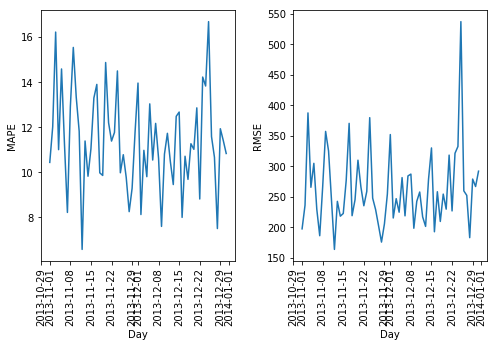

In [52]:
#del y_date[2]
# fig, (ax1,ax2) = plt.subplots(1,2, figsize =(8,6))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# ax1.xaxis.set_major_locator(mdates.DayLocator())
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# ax2.xaxis.set_major_locator(mdates.DayLocator())
# ax1.plot(y_date,Mape_date)
# ax2.plot(y_date,rmse_date)
# fig.autofmt_xdate()
# ax1.set_xlabel('k')
# ax1.set_ylabel('cost')
date_time = pd.to_datetime(y_date)
DF = pd.DataFrame()
DF['Mape_date'] = Mape_date
DF = DF.set_index(date_time)

DF1 = pd.DataFrame()
DF1['rmse_date'] = rmse_date
DF1 = DF1.set_index(date_time)
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(8,6))
fig.subplots_adjust(bottom=0.3,wspace = 0.3)
error = ["MAPE","RMSE"]
cnt = 0
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    plt.xlabel("Day")
    plt.ylabel(error[cnt])
    cnt += 1
ax1.plot(DF)
ax2.plot(DF1)

In [53]:
from statistics import mean
print("Mean RMSE = {}, Mean Mape = {}".format(mean(rmse_date),mean(Mape_date)))

Mean RMSE = 261.8336723907792, Mean Mape = 11.364451988937452


In [39]:
actual_predicted = aggregate_df.where((aggregate_df.date==date(2013,11,29))).select("label","prediction").toPandas()
actual_predicted.head()

,label,prediction
0,1673.318,1432.482789
1,1770.985,1443.964637
2,2698.482,2303.040835
3,1620.043,1352.062822
4,1242.961,1032.584991


Text(0, 0.5, 'Load (Kw/h)')

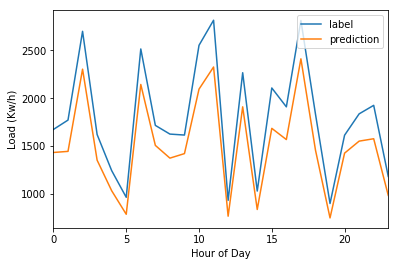

In [40]:
ax = actual_predicted.plot()
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Load (Kw/h)")